# System Design Agent

In [1]:
from dotenv import load_dotenv

load_dotenv()

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

### State

In [2]:
from typing import Annotated, TypedDict
from operator import add
from langgraph.graph import MessagesState
from pydantic import BaseModel, Field


class State(MessagesState):
    query: str
    system: str 
    plan: str
    sources: Annotated[list[str], add]
    context: str
    report: str


class ThoughtFormat(BaseModel):
    system: str = Field(
        description="Identified system from the user query.",
    )
    plan: str = Field(
        description="The plan for the system design",
    )

class ResourcesFormat(BaseModel):
    info: str
    url: str
    source: str

### nodes

In [3]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

config = {"configurable": {"thread_id": "1"}}

In [4]:
system_prompt: str = """
You are a helpful assistant with an expertise in System Design.
Please derive at a system name only from this query: {query}
Once we have a system name, lets create a step by step plan to system design guide to propose to the user.
"""

In [5]:
def thinking_node(state: State):
    print('--Thinking node--')
    structured_llm = llm.with_structured_output(ThoughtFormat)
    system_message = system_prompt.format(query=state['query'])
    history = [SystemMessage(content=system_message)]+[HumanMessage(content=state['query'])]
    state['messages'] = history
    res = structured_llm.invoke(history)
    plan = res.plan
    return {
        'system': res.system,
        'plan': plan,
        'messages': [AIMessage(content=plan)]
    }

In [6]:
from langchain_tavily import TavilySearch
from langchain_core.tools import tool


@tool
def web_search(query: str) -> str:
    """Search the web for a query."""
    tavily_search_tool = TavilySearch(
        max_results=3,
        topic="general",
    )
    return tavily_search_tool.invoke(query)


In [7]:
def gather_resources_node(state: State):
    print('--gather_resources_node--')
    gather_resources_prompt = f"""
    Given the plan: {state['plan']}, Please search for appropriate resources and list the sources
    """
    res_fmt_tool_llm = llm.bind_tools([web_search]).with_structured_output(ResourcesFormat)
    history = state['messages']
    history+= [HumanMessage(content=gather_resources_prompt)]
    res = res_fmt_tool_llm.invoke(history)
    state['messages'] = history
    ai_msg = f"""Info: {res.info}
    URL: {res.url}
    """
    print('done')
    return {
        'sources': [res.source],
        'messages': [AIMessage(content=ai_msg)],
        'context': f'System under consideration: {state["system"]}' + ai_msg
    }

In [8]:
def create_report(state: State):
    print('create-report')
    llm_with_tools = llm.bind_tools([web_search])
    final_report_prompt: str = f"""You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the system: 
{state['system']}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the system
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

    res = llm_with_tools.invoke([SystemMessage(content=final_report_prompt)]+[HumanMessage(content=f"Use this source to write final report: {state['context']}")])
    print(res.content)
    return {
        'report': res.content,
        'messages': [AIMessage(content=res.content)]
    }

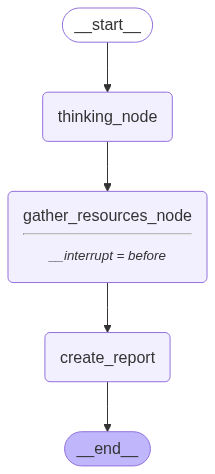

In [9]:
from IPython.display import Image, display, Markdown
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode


builder = StateGraph(State)
builder.add_node("thinking_node", thinking_node)
builder.add_node("gather_resources_node", gather_resources_node)
builder.add_node("create_report", create_report)
builder.add_edge(START, "thinking_node")
builder.add_edge("thinking_node", "gather_resources_node")

builder.add_edge("gather_resources_node", "create_report")
builder.add_conditional_edges(
	"gather_resources_node",
	create_report
)
builder.add_edge("create_report", END)
graph = builder.compile(interrupt_before=['gather_resources_node'], checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
query='help me designing fb clone'

async for event in graph.astream({'query': query}, config=config, stream_mode='values'):
    if event['messages']:
        event['messages'][-1].pretty_print()
    else:
        print(event)
Markdown(graph.get_state(config).values['plan'])

{'messages': [], 'query': 'help me designing fb clone', 'sources': []}
--Thinking node--
================================== Ai Message ==================================

Step-by-step guide to design a Social Media Platform:
1.  **Understand Requirements**: Define functional (e.g., user profiles, news feed, friending, messaging, content sharing, likes/comments) and non-functional requirements (e.g., scalability, availability, consistency, performance, security).
2.  **High-Level Architecture**: Outline core services (e.g., User Service, Post Service, News Feed Service, Chat Service, Friendship Service, Notification Service) and choose an architectural style (e.g., Microservices).
3.  **Data Modeling & Storage**: Design database schemas for different entities (users, posts, comments, messages, friendships). Select appropriate database types (e.g., SQL for user data, NoSQL for posts/feed, Graph DB for connections).
4.  **API Design**: Define the APIs for services, considering RESTful or 

Step-by-step guide to design a Social Media Platform:
1.  **Understand Requirements**: Define functional (e.g., user profiles, news feed, friending, messaging, content sharing, likes/comments) and non-functional requirements (e.g., scalability, availability, consistency, performance, security).
2.  **High-Level Architecture**: Outline core services (e.g., User Service, Post Service, News Feed Service, Chat Service, Friendship Service, Notification Service) and choose an architectural style (e.g., Microservices).
3.  **Data Modeling & Storage**: Design database schemas for different entities (users, posts, comments, messages, friendships). Select appropriate database types (e.g., SQL for user data, NoSQL for posts/feed, Graph DB for connections).
4.  **API Design**: Define the APIs for services, considering RESTful or GraphQL approaches.
5.  **Core Feature Design (Detailed)**:
    *   **User Management**: Registration, authentication, profile management.
    *   **News Feed**: Design feed generation (fan-out on write/read) and delivery mechanisms.
    *   **Content Sharing**: Handle photo/video uploads, storage (CDN), and retrieval.
    *   **Friendship/Connections**: Manage friend requests, connections, and follower graphs.
    *   **Messaging/Chat**: Implement real-time communication (e.g., using WebSockets).
    *   **Likes/Comments**: Design mechanisms for interactions on posts.
6.  **Scalability & Performance**: Implement strategies such as load balancing, caching (e.g., Redis), sharding, message queues (e.g., Kafka) for asynchronous tasks, and CDN for media delivery.
7.  **Reliability & Availability**: Plan for redundancy, replication, fault tolerance, and disaster recovery.
8.  **Security**: Address authentication (e.g., OAuth2, JWT), authorization, data encryption, and protection against common web vulnerabilities.
9.  **Monitoring & Deployment**: Outline monitoring strategies, logging, CI/CD pipelines, containerization (Docker, Kubernetes), and cloud infrastructure considerations.

In [11]:
shall_we_proceed = input("Shall we proceed with the plan): ")

if shall_we_proceed == "yes":
    async for event in graph.astream(None, config=config, stream_mode='values'):
        if event['messages']:
            event['messages'][-1].pretty_print()
        else:
            print(event)

================================== Ai Message ==================================

Step-by-step guide to design a Social Media Platform:
1.  **Understand Requirements**: Define functional (e.g., user profiles, news feed, friending, messaging, content sharing, likes/comments) and non-functional requirements (e.g., scalability, availability, consistency, performance, security).
2.  **High-Level Architecture**: Outline core services (e.g., User Service, Post Service, News Feed Service, Chat Service, Friendship Service, Notification Service) and choose an architectural style (e.g., Microservices).
3.  **Data Modeling & Storage**: Design database schemas for different entities (users, posts, comments, messages, friendships). Select appropriate database types (e.g., SQL for user data, NoSQL for posts/feed, Graph DB for connections).
4.  **API Design**: Define the APIs for services, considering RESTful or GraphQL approaches.
5.  **Core Feature Design (Detailed)**:
    *   **User Management**: 

Task gather_resources_node with path ('__pregel_pull', 'gather_resources_node') wrote to unknown channel branch:to:{'report': '## Building a Blazing Fast Social Media Feed: A Deep Dive into Scalability\n\n### Summary\nThe backbone of any successful social media platform is its feed, a dynamic and constantly updated stream of content tailored to each user. Designing a scalable and responsive social media feed presents unique technical challenges, particularly as user bases grow into the millions or even billions. The core objective is to deliver relevant content quickly and efficiently, a task that necessitates sophisticated architectural choices beyond simple database queries.\n\nA key design consideration revolves around the "fan-out" mechanism, which dictates how content is distributed to users. Two primary strategies emerge: fan-out on write and fan-out on read [1]. Fan-out on write, often employed for smaller user bases or when immediate delivery is paramount, involves pushing new 

## Building a Blazing Fast Social Media Feed: A Deep Dive into Scalability

### Summary
The backbone of any successful social media platform is its feed, a dynamic and constantly updated stream of content tailored to each user. Designing a scalable and responsive social media feed presents unique technical challenges, particularly as user bases grow into the millions or even billions. The core objective is to deliver relevant content quickly and efficiently, a task that necessitates sophisticated architectural choices beyond simple database queries.

A key design consideration revolves around the "fan-out" mechanism, which dictates how content is distributed to users. Two primary strategies emerge: fan-out on write and fan-out on read [1]. Fan-out on write, often employed for smaller user bases or when immediate delivery is paramount, involves pushing new content directly to all followers' inboxes upon creation. While ensuring low read latency, this approach can become resource-intensi

### final_report

In [15]:
Markdown(graph.get_state(config).values['report'])

## Architecting the Future of Social Media: Designing Scalable Feeds

### Summary
In the dynamic landscape of social media, the user's feed is the cornerstone of engagement, serving as the primary interface for content consumption. As platforms scale to accommodate millions, or even billions, of users and posts, the underlying architecture of this feed becomes incredibly complex and critical to performance. The challenge lies in delivering a personalized, up-to-date, and highly available stream of content efficiently, a task that demands sophisticated design choices [1].

One of the most interesting and often counter-intuitive insights in social media feed design revolves around the fan-out strategy. Traditionally, one might assume a "fan-out on read" approach, where a user's feed is constructed dynamically by querying all their friends' posts at the moment they open the app. While simpler for smaller systems, this becomes prohibitively expensive and slow at scale. The more novel and widely adopted approach for large social media platforms is "fan-out on write" [1]. This involves pre-generating and pushing content to users' individual inboxes (or feeds) as soon as it's posted. For instance, when a user posts an update, that update is immediately written to the feeds of all their followers. This shifts the computational burden from read-time to write-time, ensuring lightning-fast feed loading for the end-user, even if it means more complex write operations for the system.

However, a pure fan-out on write strategy can be inefficient for users with an extremely high number of followers (e.g., celebrities), leading to massive write amplification. This is where a hybrid approach, combining fan-out on write for most users and fan-out on read for high-follower accounts, becomes essential [1]. Caching is another pivotal element, dramatically reducing database load by storing frequently accessed data closer to the user. Furthermore, advanced ranking algorithms are crucial not just for showing content, but for curating the most relevant and engaging content, ensuring users see what matters most to them amidst a deluge of information [1]. These combined strategies represent a sophisticated engineering feat, enabling the seamless and personalized social media experiences we've come to expect.

### Sources
[1] https://blog.bytebytego.com/p/how-to-design-a-social-media-feed